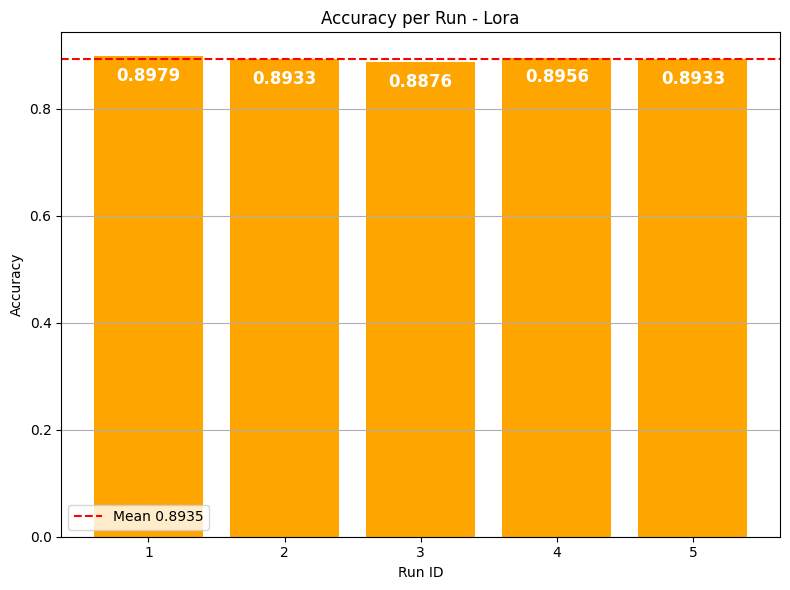

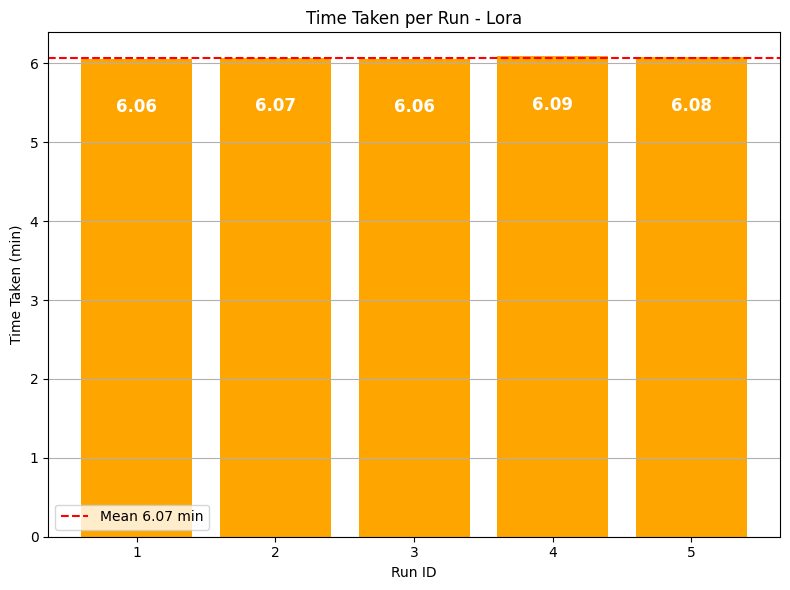

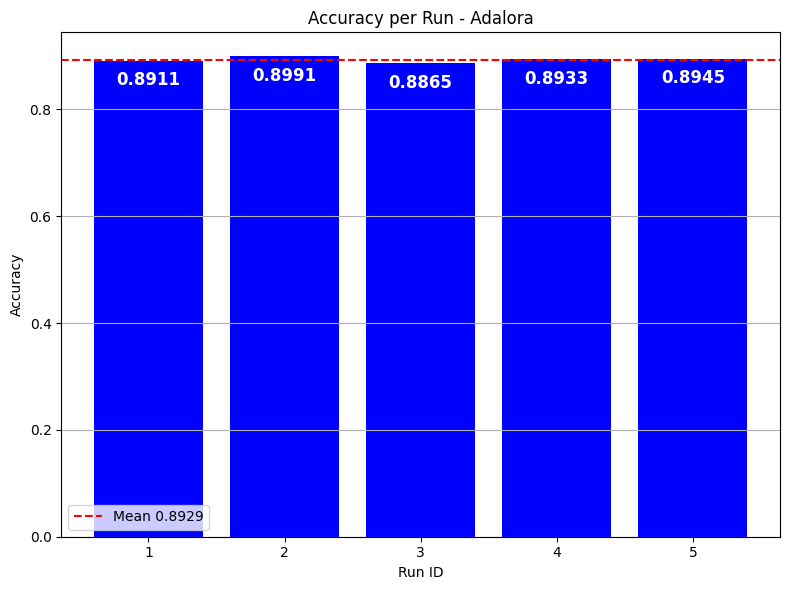

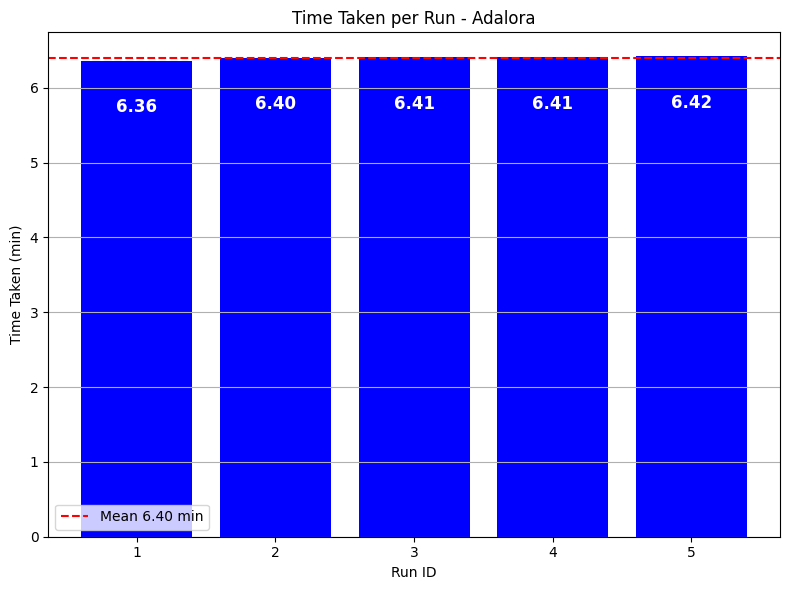

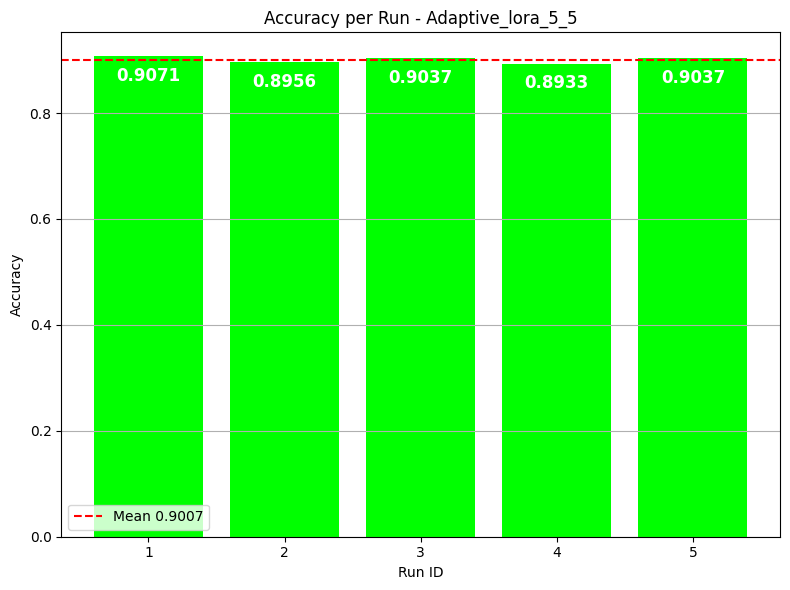

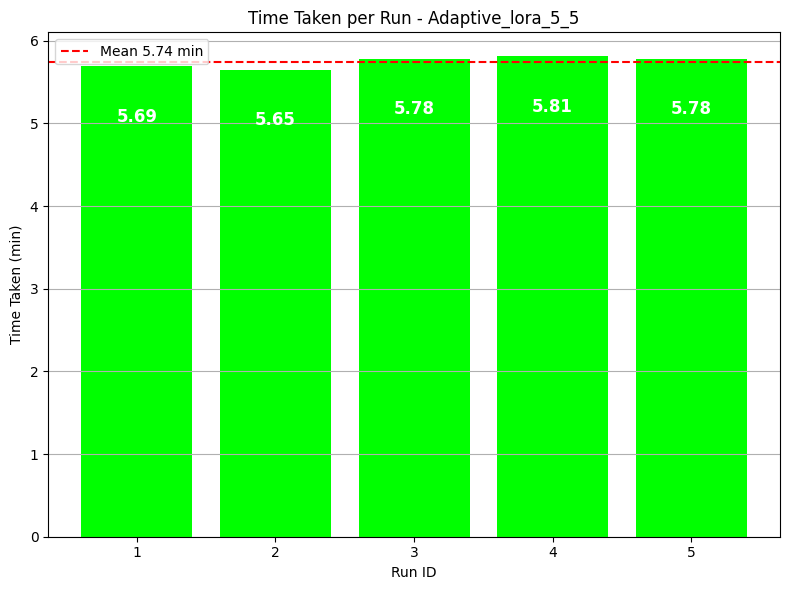

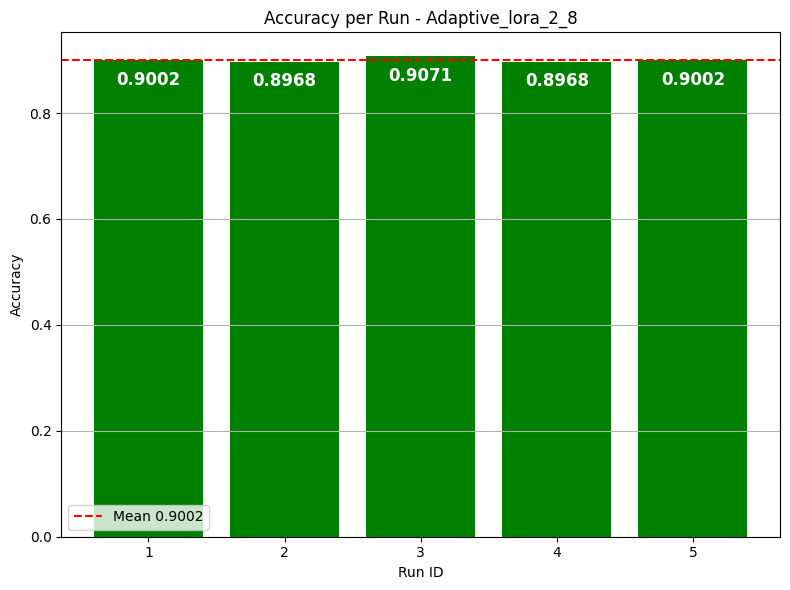

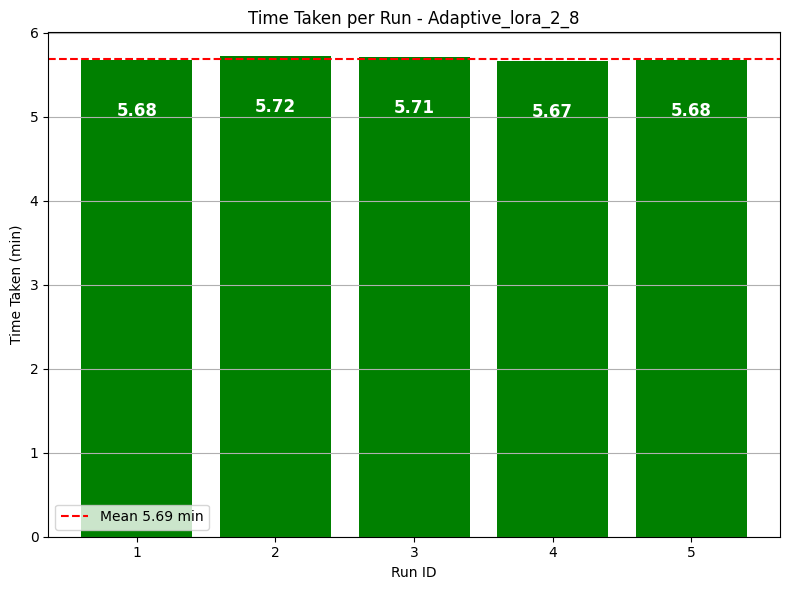

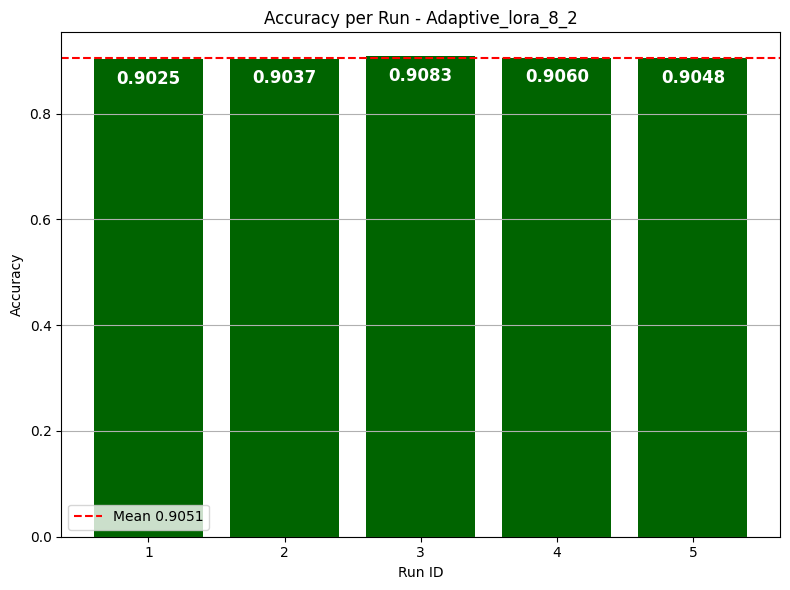

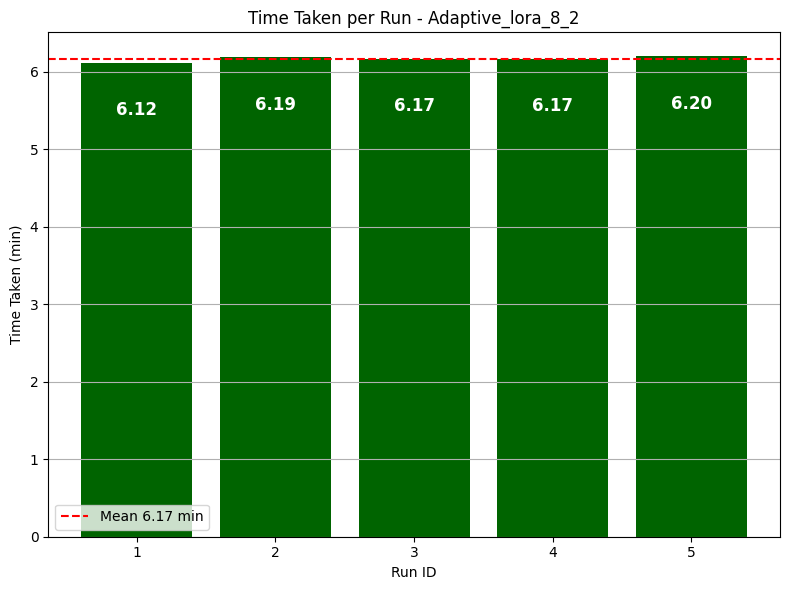

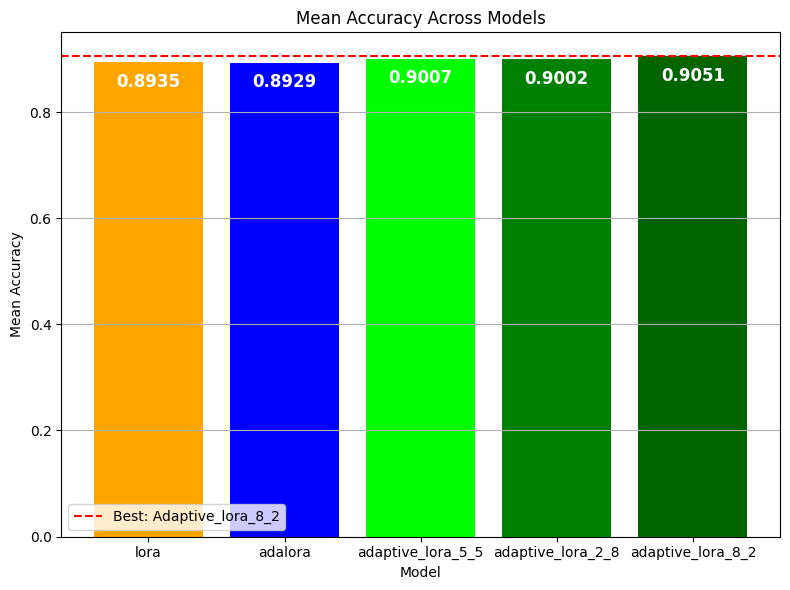

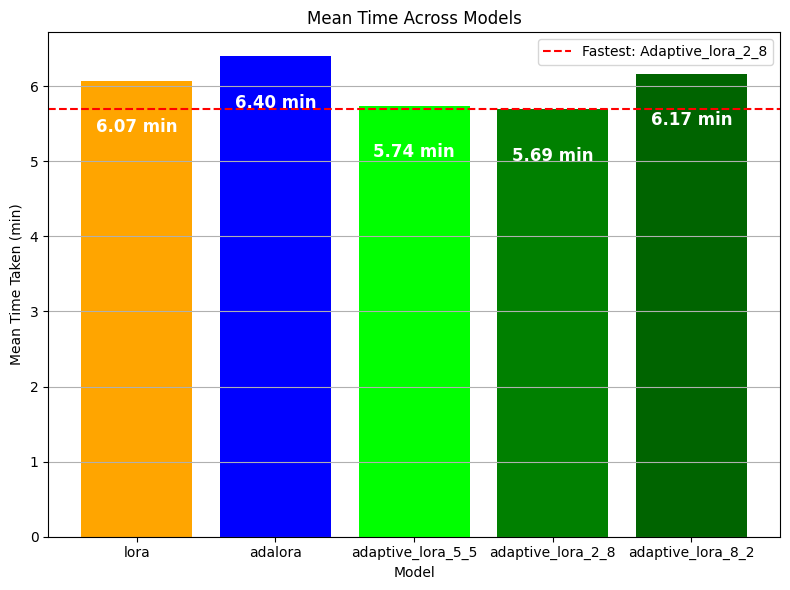

In [ ]:
# ========================
# Final - LoRA Variants Analysis Notebook
# ========================

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create output folder
os.makedirs("plots", exist_ok=True)

# ========================
# Load all CSVs
# ========================

def load_data():
    data = {}
    models = ["lora", "adalora", "adaptive_lora_5_5", "adaptive_lora_2_8", "adaptive_lora_8_2"]
    for model in models:
        phase = pd.read_csv(f"{model}_gpu_phase_timestamps.csv")
        usage = pd.read_csv(f"{model}_gpu_usage_log.csv")
        benchmark = pd.read_csv(f"{model}_sst2_benchmark.csv")
        data[model] = {
            "phase": phase,
            "usage": usage,
            "benchmark": benchmark
        }
    return data

# ========================
# Preprocessing Functions
# ========================

def preprocess_usage(df):
    df.columns = ["timestamp", "gpu_utilization", "memory_usage"]
    df["timestamp"] = df["timestamp"] - df["timestamp"].iloc[0]  # convert to time from 0
    return df

def preprocess_phase(df):
    df.columns = ["run", "phase", "timestamp"]
    return df

def preprocess_benchmark(df, model_name):
    if model_name == "adaptive_lora":
        df = df[["Run ID", "Total Time (min)", "Final Accuracy"]]
        df.columns = ["run", "time", "accuracy"]
    else:
        df = df[["Run ID", "Training Time (min)", "Final Accuracy"]]
        df.columns = ["run", "time", "accuracy"]
    return df[df["run"] != 0]

# ========================
# Plotting Functions
# ========================

model_colors = {
    "lora": "orange",
    "adalora": "blue",
    "adaptive_lora_5_5": "lime",
    "adaptive_lora_2_8": "green",
    "adaptive_lora_8_2": "darkgreen"
}

def plot_accuracy_per_run(benchmark_df, model_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    runs = benchmark_df["run"]
    accuracies = benchmark_df["accuracy"]
    mean_acc = accuracies.mean()

    bars = plt.bar(runs, accuracies, color=model_colors[model_name])

    plt.axhline(mean_acc, linestyle="--", color="red", label=f"Mean {mean_acc:.4f}")

    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.0,
            yval - 0.02,
            f"{yval:.4f}",
            ha='center',
            va='top',
            color='white',
            fontsize=12,
            fontweight='bold'
        )

    plt.xlabel("Run ID")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy per Run - {model_name.capitalize()}")
    plt.grid(axis="y")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{model_name}_accuracy_per_run.png")
    plt.show()

def plot_time_per_run(benchmark_df, model_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    runs = benchmark_df["run"]
    times = benchmark_df["time"]
    mean_time = times.mean()

    bars = plt.bar(runs, times, color=model_colors[model_name])

    plt.axhline(mean_time, linestyle="--", color="red", label=f"Mean {mean_time:.2f} min")

    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.0,
            yval - 0.5,
            f"{yval:.2f}",
            ha='center',
            va='top',
            color='white',
            fontsize=12,
            fontweight='bold'
        )

    plt.xlabel("Run ID")
    plt.ylabel("Time Taken (min)")
    plt.title(f"Time Taken per Run - {model_name.capitalize()}")
    plt.grid(axis="y")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{model_name}_time_per_run.png")
    plt.show()

def plot_mean_accuracy(models_benchmarks):
    means = {model: df["accuracy"].mean() for model, df in models_benchmarks.items()}
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = plt.bar(means.keys(), means.values(), color=[model_colors[m] for m in means.keys()])

    # Winner model (highest accuracy)
    winner_model = max(means, key=means.get)
    winner_value = means[winner_model]
    plt.axhline(winner_value, linestyle="--", color="red", label=f"Best: {winner_model.capitalize()}")

    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.0,
            yval - 0.02,
            f"{yval:.4f}",
            ha='center',
            va='top',
            color='white',
            fontsize=12,
            fontweight='bold'
        )

    plt.xlabel("Model")
    plt.ylabel("Mean Accuracy")
    plt.title("Mean Accuracy Across Models")
    plt.grid(axis="y")
    plt.legend()
    plt.tight_layout()
    plt.savefig("plots/mean_accuracy_comparison.png")
    plt.show()

def plot_mean_time(models_benchmarks):
    means = {model: df["time"].mean() for model, df in models_benchmarks.items()}
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = plt.bar(means.keys(), means.values(), color=[model_colors[m] for m in means.keys()])

    # Winner model (lowest time)
    winner_model = min(means, key=means.get)
    winner_value = means[winner_model]
    plt.axhline(winner_value, linestyle="--", color="red", label=f"Fastest: {winner_model.capitalize()}")

    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.0,
            yval - 0.5,
            f"{yval:.2f} min",
            ha='center',
            va='top',
            color='white',
            fontsize=12,
            fontweight='bold'
        )

    plt.xlabel("Model")
    plt.ylabel("Mean Time Taken (min)")
    plt.title("Mean Time Across Models")
    plt.grid(axis="y")
    plt.legend()
    plt.tight_layout()
    plt.savefig("plots/mean_time_comparison.png")
    plt.show()


# ========================
# Main Execution
# ========================

data = load_data()

for model, d in data.items():
    d["phase"] = preprocess_phase(d["phase"])
    d["usage"] = preprocess_usage(d["usage"])
    d["benchmark"] = preprocess_benchmark(d["benchmark"], model)
    # print(d["benchmark"])

# Plot per model
for model, d in data.items():
    plot_accuracy_per_run(d["benchmark"], model)
    plot_time_per_run(d["benchmark"], model)

# Cross model comparison
plot_mean_accuracy({k: v["benchmark"] for k, v in data.items()})
plot_mean_time({k: v["benchmark"] for k, v in data.items()})